Aprendizaje automático con el dataset [wines](https://archive.ics.uci.edu/ml/datasets/wine).

> Estos datos son los resultados de un análisis químico de vinos cultivados en la misma región de Italia pero procedentes de tres cultivares diferentes. El análisis determinó las cantidades de 13 componentes presentes en cada uno de los tres tipos de vino

# Instalación de paquetes

In [24]:
install.packages("keras")
install.packages("caret")
install.packages("rescale")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘rescale’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”


# Particionamiento de datos

In [26]:
library(tidyverse)
library(caret)
library(keras)
library(scales)

data <- read_csv('wines.csv') %>%
  mutate(across(!Wine, rescale)) %>%
  na.omit()

library(caret)
trainIndex <- createDataPartition(data$Wine, p = .7, list = FALSE)[,1]  ## Atencion: [,1] para versiones de tibble >= 3.0
train      <- data[trainIndex, ] 
val        <- data[-trainIndex, ]

x_train <- train %>%
  select(-Wine) %>%
  data.matrix()

y_train <- train %>%
  select(Wine) %>%
  mutate(Wine = Wine - 1) %>%
  to_categorical() %>%
  data.matrix()

Rows: 178 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): Wine, Alcohol, Malic acid, Ash, Alcalinity of ash, Magnesium, Tota...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Modelo predictivo


## Definición de red neuronal

In [29]:
model <- keras_model_sequential() %>% 
  layer_dense(units = 32, activation = "relu", input_shape = c(ncol(data) - 1)) %>%
  layer_dense(units = 16, activation = "relu") %>%
  layer_dense(units = 3, activation = "softmax")
model

Model: "sequential_3"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_11 (Dense)                   (None, 32)                      448         
 dense_10 (Dense)                   (None, 16)                      528         
 dense_9 (Dense)                    (None, 3)                       51          
Total params: 1,027
Trainable params: 1,027
Non-trainable params: 0
________________________________________________________________________________

In [30]:
model %>% compile(
  loss = 'binary_crossentropy',
  metrics = c('accuracy'),
  optimizer = optimizer_adam()
)

## Entrenamiento

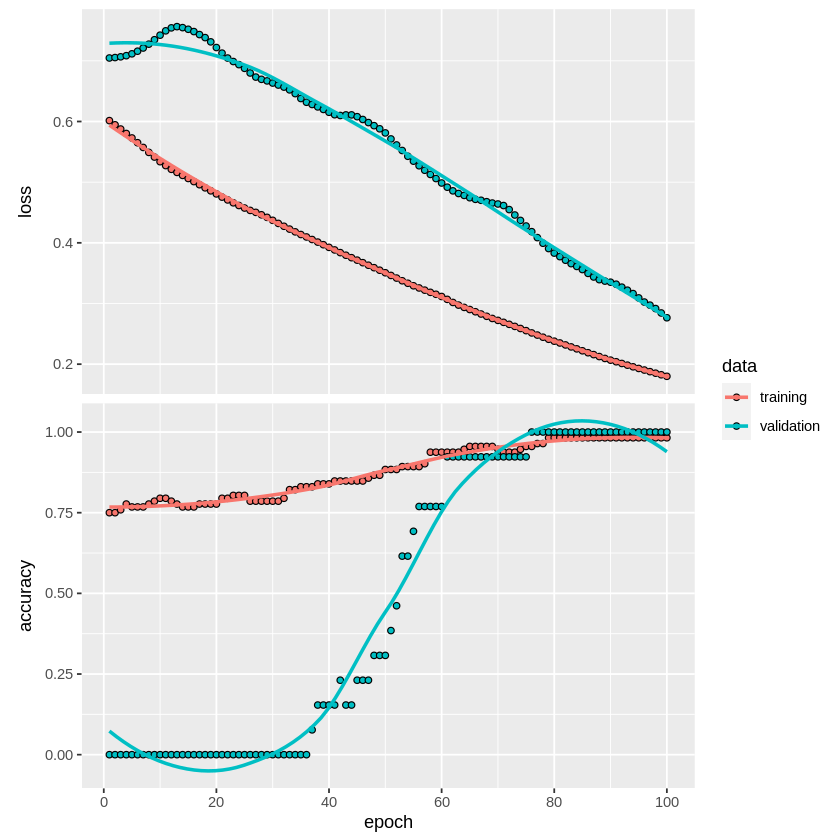

In [32]:
history <- model %>% 
  fit(
    x_train, y_train, 
    epochs = 100, 
    batch_size = 100, 
    validation_split = 0.10
  )
plot(history)

## Evaluación del modelo

In [33]:
x_val <- val %>%
  select(-Wine) %>%
  data.matrix()

y_val <- val %>%
  select(Wine) %>%
  mutate(Wine = Wine - 1) %>%
  to_categorical() %>%
  data.matrix()

model %>% evaluate(x_val, y_val)

loss  accuracy 
0.1713434 1.0000000

## Predicción

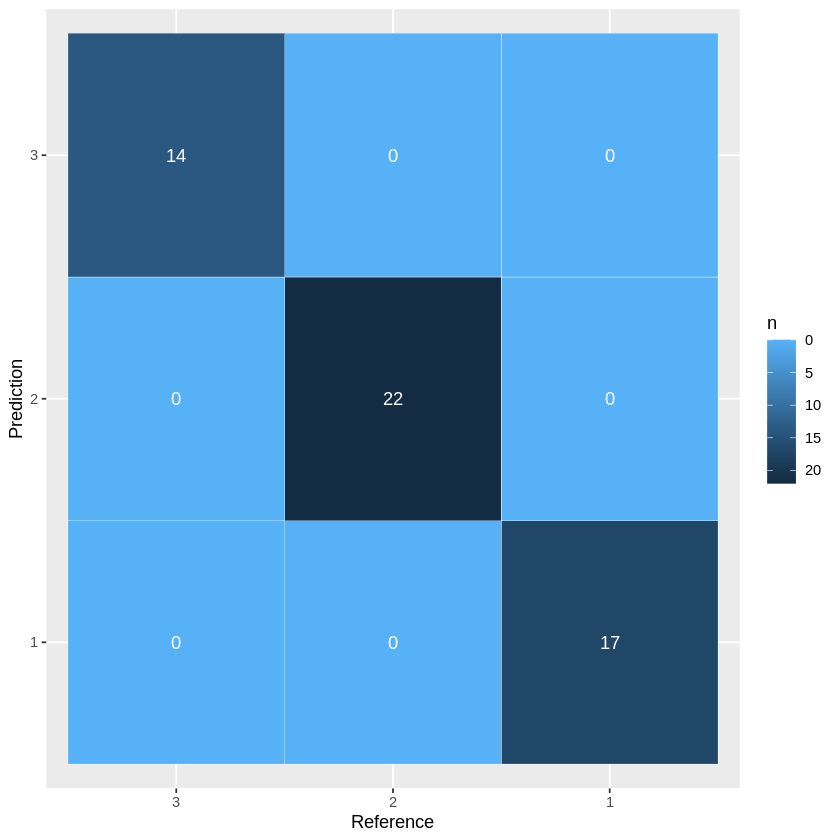

In [59]:
predictions <- model %>% 
  predict(x_val) %>% 
  `>`(0.5) %>% 
  k_cast("int32") %>%
  data.matrix() %>%
  as_tibble() %>%
  max.col()

outputs <- y_val %>%
  as_tibble() %>%
  max.col()

cm <- confusionMatrix(as.factor(outputs), as.factor(predictions))
cm_prop <- prop.table(cm$table)

library(scales)
cm_tibble <- as_tibble(cm$table) 

ggplot(data = cm_tibble) + 
  geom_tile(aes(x=Reference, y=Prediction, fill=n), colour = "white") +
  geom_text(aes(x=Reference, y=Prediction, label=n), colour = "white") +
  scale_fill_continuous(trans = 'reverse') +
  scale_x_discrete(limits=rev)